<a href="https://colab.research.google.com/github/wanderloop/WanderlustAI/blob/master/midpoint_to_coo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from pandas import DataFrame, read_csv, concat
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
!pip install pandas_profiling==2.8.0
from pandas_profiling import ProfileReport
from numpy import nan, linspace, min, max, sqrt, ravel
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from plotly.figure_factory import create_table
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
!pip install hummingbird-ml
from hummingbird.ml import convert
from gc import collect
from pickle import dump
from io import BytesIO
from google.colab import files
uploaded = files.upload()

ONNX runtime not installed. Please check https://github.com/microsoft/onnxruntime#installation for instructions.
ONNX runtime not installed. Please check https://github.com/microsoft/onnxruntime#installation for instructions.


Saving assumed_PHA.csv to assumed_PHA.csv


In [ ]:
df = read_csv(BytesIO(uploaded['assumed_PHA.csv']))
keep_cols = ['MID_POINT_X', 
             'MID_POINT_Y',
             'lat',]
imp = SimpleImputer(missing_values=nan,
                    strategy='median',)
df[keep_cols] = imp.fit_transform(df[keep_cols])
df = df.loc[:, keep_cols]
data = create_table(df.head())
data.show()

In [ ]:
df.rename(columns={'MID_POINT_X': 'MPX',
                   'MID_POINT_Y': 'MPY',},
          inplace=True,)
ren = create_table(df.head())
ren.show()

In [ ]:
print(df.columns.values)

['MPX' 'MPY' 'lat']


In [ ]:
tail = create_table(df.tail())
tail.show()

In [ ]:
df1, df2 = df.head(), df.tail()
conc_data_row = concat([df1,
                        df2,],
                        axis=0, # Adds dataframes in row
                        join='outer',)

conc_data_row = create_table(conc_data_row)
conc_data_row.show()

In [ ]:
del conc_data_row
collect()

44

In [ ]:
del df1
collect()

0

In [ ]:
del df2
collect()

0

In [ ]:
assert df['MPX'].notnull().all()
assert df['MPY'].notnull().all()
assert df['lat'].notnull().all()

In [ ]:
print('Duplicated entries:',
      df.duplicated().sum())
df[df.duplicated()].isna().median()

Duplicated entries: 0


MPX   NaN
MPY   NaN
lat   NaN
dtype: float64

In [ ]:
df.drop_duplicates(subset=df.columns.values[:-1],
                   keep='first',
                   inplace=True,)
print(df.shape, "Duplicated rows have been removed.")

(18, 3) Duplicated rows have been removed.


In [ ]:
# Dropping columns with more than 50% missing values
df = df.dropna(thresh=df.shape[0]*0.5,
               how='all',
               axis=1,)

In [ ]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18 entries, 0 to 17
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   MPX     18 non-null     float64
 1   MPY     18 non-null     float64
 2   lat     18 non-null     float64
dtypes: float64(3)
memory usage: 576.0 bytes


In [ ]:
profile = ProfileReport(df,
                        title='Midpoint-Coo Report',
                        explorative=True,
                        progress_bar=True,)
profile.to_notebook_iframe()

In [ ]:
del profile
collect()

59334

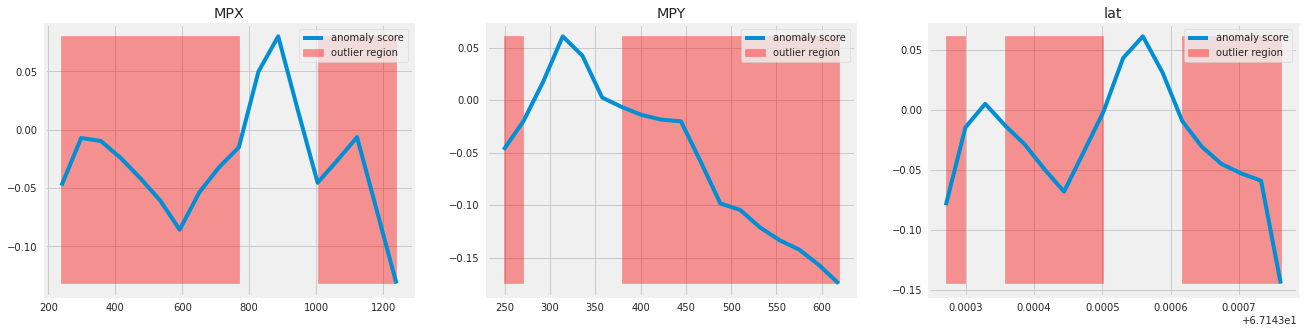

In [ ]:
cols = ['MPX',
        'MPY',
        'lat',]
fig, axs = plt.subplots(1,
                        3,
                        figsize=(20, 5),
                        facecolor='w',
                        edgecolor='k',)
axs = axs.ravel()

for i, column in enumerate(cols):
    isolation_forest = IsolationForest(contamination='auto')
    isolation_forest.fit(df[column].to_numpy().reshape(-1, 1))

    xx = linspace(df[column].min(),
                  df[column].max(),
                  len(df)).reshape(-1, 1)
    anomaly_score = isolation_forest.decision_function(xx)
    outlier = isolation_forest.predict(xx)
    
    axs[i].plot(xx,
                anomaly_score,
                label='anomaly score',)
    axs[i].fill_between(xx.T[0],
                        min(anomaly_score),
                        max(anomaly_score), 
                        where=outlier==-1,
                        color='r', 
                        alpha=.4,
                        label='outlier region',)
    axs[i].legend(frameon=True)
    axs[i].set_title(column)

In [ ]:
sc_X = StandardScaler()
sc_y = StandardScaler()

In [ ]:
X = df[['MPX',
        'MPY',]]
y = df['lat']

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.2, 
                                                    random_state = 0,)

In [ ]:
y_train = y_train.to_numpy().reshape(-1,1)
y_test = y_test.to_numpy().reshape(-1,1)

In [ ]:
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.fit_transform(X_test)
y_train = sc_X.fit_transform(y_train)
y_test = sc_y.fit_transform(y_test)

In [ ]:
X_train

array([[ 0.48285782, -0.6016222 ],
       [-0.89310049, -0.41492231],
       [ 1.57625326, -0.48281318],
       [-1.29083844,  2.02914893],
       [-1.02209658,  1.94852852],
       [-0.4354715 , -0.75013347],
       [ 0.84220408, -1.10656053],
       [ 1.16930131, -1.05564238],
       [ 1.09405359, -0.38097688],
       [ 0.48285782, -0.65678353],
       [-1.24783974,  0.65860203],
       [ 0.4506088 ,  0.64162932],
       [-1.49508225,  0.78589741],
       [ 0.28629235, -0.61435174]])

In [ ]:
regr = LinearRegression()
regr.fit(X_train,
         y_train,)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
del X_train
collect()

24556

In [ ]:
del y_train
collect()

0

In [ ]:
del sc_X
collect()

0

In [ ]:
del sc_y
collect()

0

In [ ]:
model = convert(regr, 'pytorch')
print(type(model))

<class 'hummingbird.ml._container.PyTorchBackendModelRegression'>


In [ ]:
model.to('cuda')

PyTorchBackendModelRegression(
  (operator_map): ModuleDict(
    (SklearnLinearRegression): SklearnLinearModel()
  )
)

In [ ]:
y_pred = regr.predict(X_test)
print(X_test)
print(y_pred)

[[ 0.2809999   0.98712511]
 [ 1.21416001 -1.09964715]
 [ 0.0676203  -0.89506163]
 [-1.56278022  1.00758366]]
[[-0.52130228]
 [ 1.16476401]
 [ 0.59598275]
 [-1.23944448]]


In [ ]:
print('Coefficients:', 
      regr.coef_,)

print('Mean absolute error: %.2f'
      % mean_absolute_error(y_test,
                            y_pred.ravel(),))

print('Mean squared error: %.2f'
      % mean_squared_error(y_test,
                           y_pred.ravel(),))

print('Root mean square error: %.2f'
      % sqrt(mean_squared_error(y_test,
                                y_pred.ravel(),)))

print('Coefficient of determination: %.2f'
      % r2_score(y_test, 
                 y_pred.ravel(),))

print('Explained variance score: %.2f'
      % explained_variance_score(y_test,
                                 y_pred.ravel(),))

Coefficients: [[ 0.38242674 -0.63696501]]
Mean absolute error: 0.17
Mean squared error: 0.03
Root mean square error: 0.17
Coefficient of determination: 0.97
Explained variance score: 0.97


In [ ]:
df = DataFrame({'Actual': y_test.flatten(),
                'Predicted': y_pred.flatten(),})

res = create_table(df.head())
res.show()

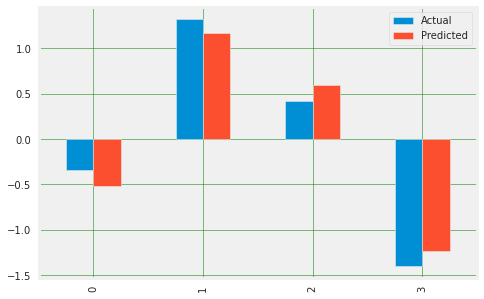

In [ ]:
df.plot(kind='bar',
        figsize=(7, 5))

plt.grid(which='major', 
         linestyle='-', 
         linewidth='0.5', 
         color='green',)

plt.grid(which='minor', 
         linestyle=':', 
         linewidth='0.5', 
         color='black',)

plt.legend(frameon=True)
plt.show()

In [ ]:
del X_test
collect()

0

In [ ]:
del y_pred
collect()

0

In [ ]:
del y_test
collect()

0

In [ ]:
regr.predict([[1107,
               255,]])

array([[260.92032403]])

In [ ]:
pickle_out=open("dict1.pickle",
                "wb",)
dump(regr,
     pickle_out,)

In [ ]:
pickle_out.close()

In [ ]:
del pickle_out
collect()

0

In [ ]:
!ls

assumed_PHA.csv  dict1.pickle  sample_data


In [ ]:
!pip freeze | grep scikit-learn

scikit-learn==0.22.2.post1
